# 데이터 및 라이브러리 셋팅

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!mkdir yolo_labels
!kaggle datasets download -d awsaf49/vinbigdata-yolo-labels-dataset
!kaggle datasets download -d awsaf49/vinbigdata-512-image-dataset

In [ ]:
!unzip -d /content/yolo_labels /content/vinbigdata-yolo-labels-dataset.zip
!unzip /content/vinbigdata-512-image-dataset.zip

!rm /content/vinbigdata-512-image-dataset.zip
!rm /content/vinbigdata-yolo-labels-dataset.zip

In [ ]:
# PIP Installs
!/opt/conda/bin/python3.7 -m pip install -q --upgrade pip      # Upgrade PIP
!pip install -q pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg # Install/Upgrade PyDicom Dependencies

# Machine Learning and Data Science Imports
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from skimage import exposure
import pandas as pd; pd.options.mode.chained_assignment = None
import numpy as np
import scipy

# Built In Imports
from datetime import datetime
from glob import glob
import warnings
import IPython
import urllib
import zipfile
import pickle
import shutil
import string
import math
import tqdm
import time
import os
import gc
import re

# Visualization Imports
from google.colab.patches import cv2_imshow
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from PIL import Image
import matplotlib
import plotly
import PIL
import cv2

# PRESETS
FIG_FONT = dict(family="Helvetica, Arial", size=14, color="#7f7f7f")
LABEL_COLORS = [px.colors.label_rgb(px.colors.convert_to_RGB_255(x)) for x in sns.color_palette("Spectral", 15)]
LABEL_COLORS_WOUT_NO_FINDING = LABEL_COLORS[:8]+LABEL_COLORS[9:]
from tqdm.notebook import tqdm


/bin/bash: /opt/conda/bin/python3.7: No such file or directory


In [154]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [155]:
configure_plotly_browser_state()

# EDA

이번 대회에서는 흉부 X-ray 이미지를 통해 병변을 찾고 분류하는, object detection and classification task이다.

각 테스트이미지마다 바운딩박스와 클래스를 예측한 값들을 csv파일로 만들어 제출한다.

병변이 없는경우(no findings), 정상일 경우에는 14 1 0 0 1 1 이렇게 표시한다(14는 no finding의 라벨)


- **DATA FILES**

train.csv - 훈련 이미지에 대한 정보들이 담겨있음.
하나의 이미지에 여러 라벨 및 어노테이션들이 있으므로 이미지 파일 이름이 중복되어 존재한다.


sample_submission.csv - 제출용 형식

In [ ]:
train_df = pd.read_csv('/content/vinbigdata/train.csv')
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072


In [ ]:
ss_df = pd.read_csv('/content/vinbigdata/sample_submission.csv')
ss_df.head()

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,14 1 0 0 1 1
1,004f33259ee4aef671c2b95d54e4be68,14 1 0 0 1 1
2,008bdde2af2462e86fd373a445d0f4cd,14 1 0 0 1 1
3,009bc039326338823ca3aa84381f17f1,14 1 0 0 1 1
4,00a2145de1886cb9eb88869c85d74080,14 1 0 0 1 1


**TRAIN COLUMNS**

image_id - 이미지 파일 이름

class_name - 병명 이름 (or "No finding")

class_id - 병명 라벨

rad_id - 해당 어노테이션을 붙인 방사선전문의 id(사용x)

x_min - 바운딩 박스 최소값 x의 좌표

y_min - 바운딩 박스 최소값 y의 좌표


x_max - 바운딩 박스 최댓값 x의 좌표

y_max - 바운딩 박스 최댓값 y의 좌표

In [ ]:
test_img_wh = pd.read_csv('/content/vinbigdata/test.csv')
test_img_wh.head()

,image_id,width,height
0,83caa8a85e03606cf57e49147d7ac569,2304,2880
1,7550347fa2bb96c2354a3716dfa3a69c,2538,3095
2,74b23792db329cff5843e36efb8aa65a,2788,3120
3,94568a546be103177cb582d3e91cd2d8,1994,2430
4,6da36354fc904b63bc03eb3884e0c35c,2056,2376


test.csv의 경우 정답 라벨은 캐글에서 갖고 있으며 이미지의 너비, 높이만 제공된다.

In [ ]:
sorted(train_df.class_id.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

- **DATASET INFORMATION**

train.csv의 경우 14가지의 라벨이 존재.

0 - Aortic enlargement

1 - Atelectasis

2 - Calcification

3 - Cardiomegaly

4 - Consolidation

5 - ILD

6 - Infiltration

7 - Lung Opacity

8 - Nodule/Mass

9 - Other lesion

10 - Pleural effusion

11 - Pleural thickening

12 - Pneumothorax

13 - Pulmonary fibrosis

14 - "No finding" (정상)

!! 하나의 이미지에 대해 여러가지 라벨이 존재.


In [ ]:
train_img_path = glob.glob('./vinbigdata/train/*.png')
test_img_path = glob.glob('./vinbigdata/test/*.png')

In [ ]:
len(train_img_path), len(test_img_path)

(15000, 3000)

훈련 이미지 : 15000장

테스트 이미지 : 3000장

시각화 함수 - 레퍼런스 참고함

In [ ]:
def plot_image(img, title="", figsize=(8,8), cmap=None):
    """ Function to plot an image to save a bit of time """
    plt.figure(figsize=figsize)
    
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        img
        plt.imshow(img)
        
    plt.title(title, fontweight="bold")
    plt.axis(False)
    plt.show()
    
def get_image_id(path):
    """ Function to return the image-id from a path """
    return path.rsplit("/", 1)[1].rsplit(".", 1)[0]

def create_fractional_bbox_coordinates(row):
    """ Function to return bbox coordiantes as fractions from DF row """
    frac_x_min = row["x_min"]/row["img_width"]
    frac_x_max = row["x_max"]/row["img_width"]
    frac_y_min = row["y_min"]/row["img_height"]
    frac_y_max = row["y_max"]/row["img_height"]
    return frac_x_min, frac_x_max, frac_y_min, frac_y_max

def draw_bboxes(img, tl, br, rgb, label="", label_location="tl", opacity=0.1, line_thickness=0):
    """ TBD 
    
    Args:
        TBD
        
    Returns:
        TBD 
    """
    rect = np.uint8(np.ones((br[1]-tl[1], br[0]-tl[0], 3))*rgb)
    sub_combo = cv2.addWeighted(img[tl[1]:br[1],tl[0]:br[0],:], 1-opacity, rect, opacity, 1.0)    
    img[tl[1]:br[1],tl[0]:br[0],:] = sub_combo

    if line_thickness>0:
        img = cv2.rectangle(img, tuple(tl), tuple(br), rgb, line_thickness)
        
    if label:
        # DEFAULTS
        FONT = cv2.FONT_HERSHEY_SIMPLEX
        FONT_SCALE = 1.666
        FONT_THICKNESS = 3
        FONT_LINE_TYPE = cv2.LINE_AA
        
        if type(label)==str:
            LABEL = label.upper().replace(" ", "_")
        else:
            LABEL = f"CLASS_{label:02}"
        
        text_width, text_height = cv2.getTextSize(LABEL, FONT, FONT_SCALE, FONT_THICKNESS)[0]
        
        label_origin = {"tl":tl, "br":br, "tr":(br[0],tl[1]), "bl":(tl[0],br[1])}[label_location]
        label_offset = {
            "tl":np.array([0, -10]), "br":np.array([-text_width, text_height+10]), 
            "tr":np.array([-text_width, -10]), "bl":np.array([0, text_height+10])
        }[label_location]
        img = cv2.putText(img, LABEL, tuple(label_origin+label_offset), 
                          FONT, FONT_SCALE, rgb, FONT_THICKNESS, FONT_LINE_TYPE)
    
    return img

**이미지당 총 어노테이션 개수 분포 시각화 (중복포함)**

  -> 여기서 얻을 수 있는 인사이트
  1. 이미지 당 들어있는 라벨은 최소 3개. 어떤 이미지든 라벨이 3개이상 들어있다.
  2. 하나의 이미지에 들어있는 라벨 최댓값은 57개.
  3. 이미지 중 거의 대부분이 라벨 3개를 갖는다.(전체 15000장 중 10976장)
  4. 분포도가 왼쪽으로 많이 치우침. 왜곡도가 높다. 좋은 분포는 skew값이 0이다.



In [ ]:
train_df.image_id.value_counts()

03e6ecfa6f6fb33dfeac6ca4f9b459c9    57
fa109c087e46fe1ea27e48ce6d154d2f    52
e31be972e181987a8600a8700c1ebe88    48
6d5acf3f8a973a26844d617fffe72998    46
3a302fbbbf3364aa1a7731b59e6b98ec    46
                                    ..
be353c629cd9b269bbcb6623339283ae     3
43b0f51d257ee4154014ef7724a82644     3
9a4ed54cefaea64fc59bf8debdc79ec9     3
3018e6640df6a1e3f9978cf55c8d0fd3     3
839b2311ffad9bdd9aa98c74aad6e251     3
Name: image_id, Length: 15000, dtype: int64

In [ ]:
scipy.stats.skew(train_df.image_id.value_counts().values)

3.8687405565463298

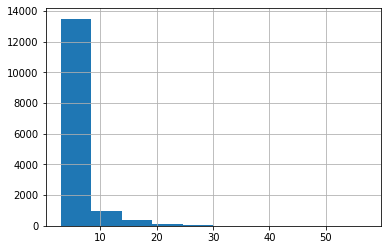

In [ ]:
train_df.image_id.value_counts().hist() 

In [ ]:
fig = px.histogram(train_df.image_id.value_counts(), 
                   log_y=True, color_discrete_sequence=['indianred'], opacity=0.7,
                   labels={"value":"Number of Annotations Per Image"},
                   title="<b>DISTRIBUTION OF # OF ANNOTATIONS PER PATIENT   " \
                         "<i><sub>(Log Scale for Y-Axis)</sub></i></b>",
                   )
fig.update_layout(showlegend=False,
                  xaxis_title="<b>Number of Unique Images</b>",
                  yaxis_title="<b>Count of All Object Annotations</b>",
                  font=FIG_FONT,)
fig.show()

**이미지 당 존재하는 병명 수 (중복x)**


  -> 여기서 얻을 수 있는 인사이트
  1. 10935장의 이미지는 하나의 병명을 가짐 => 단일 이미지에 하나의 병명이 여러 병변을 가지는 경우가 대다수.

In [ ]:
fig = px.histogram(train_df.groupby('image_id')["class_name"].unique().apply(lambda x: len(x)), 
             log_y=True, color_discrete_sequence=['skyblue'], opacity=0.7,
             labels={"value":"Number of Unique Abnormalities"},
             title="<b>DISTRIBUTION OF # OF ANNOTATIONS PER PATIENT   " \
                   "<i><sub>(Log Scale for Y-Axis)</sub></i></b>",
                   )
fig.update_layout(showlegend=False,
                  xaxis_title="<b>Number of Unique Abnormalities</b>",
                  yaxis_title="<b>Count of Unique Patients</b>",
                  font=FIG_FONT,)
fig.show()

**라벨당(병명당) 어노테이션 갯수**

In [ ]:
fig = px.bar(train_df.class_name.value_counts().sort_index(), 
             color=train_df.class_name.value_counts().sort_index().index, opacity=0.85,
             color_discrete_sequence=LABEL_COLORS, log_y=True,
             labels={"y":"Annotations Per Class", "x":""},
             title="<b>Annotations Per Class</b>",)
fig.update_layout(legend_title=None,
                  font=FIG_FONT,
                  xaxis_title="",
                  yaxis_title="<b>Annotations Per Class</b>")

fig.show()

In [ ]:
train_df = train_df[train_df.class_id!=14].reset_index(drop=True)
IMG_SIZE = 512
train_df['xmin'] = ((train_df['x_min']/train_df['width'])*IMG_SIZE).astype('int')
train_df['ymin'] = ((train_df['y_min']/train_df['height'])*IMG_SIZE).astype('int')
train_df['xmax'] = ((train_df['x_max']/train_df['width'])*IMG_SIZE).astype('int')
train_df['ymax'] = ((train_df['y_max']/train_df['height'])*IMG_SIZE).astype('int')

train_df['frac_x_min'] = train_df['x_min']/train_df['width']
train_df['frac_x_max'] = train_df['x_max']/train_df['width']
train_df['frac_y_min'] = train_df['y_min']/train_df['height']
train_df['frac_y_max'] = train_df['y_max']/train_df['height']


train_df['x_mid'] = ((train_df['xmax']+train_df['xmin'])/2)/IMG_SIZE 
train_df['y_mid'] = ((train_df['ymax']+train_df['ymin'])/2)/IMG_SIZE 
train_df['w'] = (train_df['xmax'] - train_df['xmin'])/IMG_SIZE 
train_df['h'] = (train_df['ymax'] - train_df['ymin'])/IMG_SIZE 



In [ ]:
# 만드는중...
train_dir = './vinbigdata/train/'
def visualization(train_df, img_path):
    img_id = img_path.lstrip(train_dir).rstrip('.png')
    df = train_df[train_df.image_id == img_id]
    img = cv2.imread(img_path)
    for i in range(len(df)):
        img = cv2.rectangle(img, (df.xmin,df.ymin), (df.xmax, df.ymax), (0,255,0),1)
    cv2_imshow(img)

visualization(train_df, train_img_path[0])

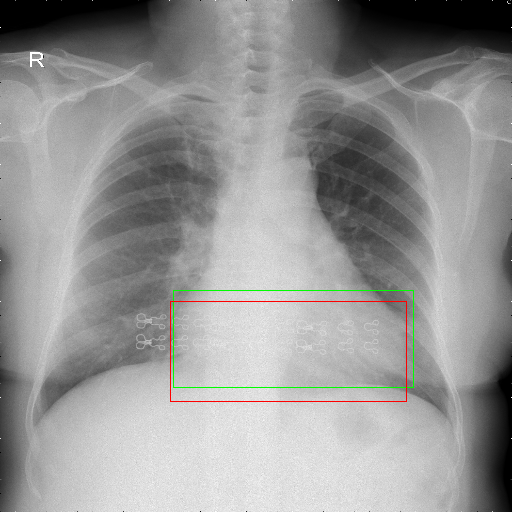

In [ ]:
img = cv2.imread('/content/vinbigdata/train/9a5094b2563a1ef3ff50dc5c7ff71345.png')
# cv2.rectangle(img, (x_min,y_min),	(x_max,y_max), 선 색, 선 굵기 )
img = cv2.rectangle(img, (173,290), (413,387), (0,255,0),1) # 예측
img = cv2.rectangle(img, (170,301),(406,401), (0,0,255),1) # 정답 
cv2_imshow(img)